# Chapter 3

Selected exercises from ISLR - Chapter 3. Solutions are written in python.

First, let's import all the packages required to run the exercises below.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import math
from scipy import stats
import statsmodels.api as sm
import scipy.stats

Links to the exercises in this notebook: <br>
[Exercise 8](#exercise-8) <br>
[Exercise 9](#exercise-9) <br>

<a id='exercise-8'></a>
## Exercise 8

This question involves the use of linear regression on the `Auto` dataset. \
As described in [Chapter 2](https://nbviewer.jupyter.org/github/maurock/ISLR/blob/main/Chapter_2.ipynb), null values in this dataset are represented by the question mark `?` \
Also, horsepower is of type `object`. We need to convert it into a quantitative feature.

In [2]:
auto = pd.read_csv('data/Auto.csv')
auto.drop(auto[auto.values == '?'].index, inplace = True)
auto['horsepower'] = pd.to_numeric(auto['horsepower'])

### 8.a - 8b
This question asks to fit a linear regression with `mpg` as response and `horsepower` as predictor. Then, it asks to analyze the relationship between the two features. Instead of using `scikit-learn.linear_model.LinearRegression()`, I define my own model from scratch for learning purposes. The coefficients are computed using linear algebra.

#### Quick refresher on Linear Regression using Linear Algebra.  <span style="background-color: #FFC300">[Theory]</span>
We group all the observations of the response in a column vector $\mathrm{y}$, while the observations of the predictor are grouped in a matrix $\mathrm{x}$. A linear model is expressed as: \
$$ y = \mathrm{x} A $$ \
where $A$ is a matrix that groups the coefficient of the linear regression model.

In this case, the matrices are: 

$\mathrm{y} = \begin{bmatrix}y_1 \\ .. \\ .. \\ y_n \end{bmatrix}$  &nbsp; &nbsp; &nbsp; $\mathrm{x} = \begin{bmatrix}1 & x_1 \\ 1 & .. \\ 1 & .. \\ 1 & x_n \end{bmatrix}$   &nbsp; &nbsp; &nbsp;  $\mathrm{A} = \begin{bmatrix}\beta_0 \\ \beta_1 \end{bmatrix}$ 

The $\mathrm{x}$ matrix is also called _design matrix_. The first column, which only contains 1s, is necessary to derive the intercept. \
Adopting matrix calculus, we can calculate $A$ as follows: 

$$ y = x A $$

$$ x^T y = x^T x A $$

$$ (x^T x)^{-1} x^T y = (x^T x)^{-1} x^T x A $$

$$ A = (x^T x)^{-1} x^T y $$



In [3]:
class Linear_Regression:
    def __init__(self):
        """
        Initialize parameters of the linear regression model. 
        In the lists, the first element refers to the intercept and the secon element refers to the coefficient.
        """
        self.intercept = None
        self.slope = None
        self.A = None
        self.t_statistics = []
        self.p_values = []
        self.SE = []
        
    def fit(self, x, y, print_statistics=False):
        """
        This function fits a linear regression model and stores the intercept and the coefficients.
        The arrays x and y are assumed to be row vectors.
        """
        X = np.zeros((x.shape[0], 2))
        X[:, 0] = 1
        X[:, 1] = x
        Y = y.reshape(-1, 1)
        self.A = np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(), X)), X.transpose()), Y)
        self.intercept, self.slope = self.A[0], self.A[1]
        self.N = x.shape[0]
        if print_statistics:
            self._hypothesis_testing(x, y)
        
    def predict(self, x):
        """
        This function predicts the response using the regression model.
        input x: row array, shape=(1, N) 
        output: column array, shape=(N, 1)
        """
        X = np.zeros((x.shape[0], 2))
        X[:, 0] = 1
        X[:, 1] = x
        return np.dot(X, self.A)
    
    def _hypothesis_testing(self, x, y):
        """
        Print a table for the t-statistics and p-value of the regression coefficients.
        The standard error of the parameters SE(..) are reported on page 66. 
        The t-scores of the parameters are calculated as B / SE(B).
        p-values are computed using a 2 sample t-test and N-2 degrees of freedom       
        """  
        N = y.shape[0]
        std_dev = math.sqrt(np.sum((y - np.ravel(self.predict(x)))**2) / (N - 1))    
        # Intercept -----------------
        # SE on page 66
        self.SE_intercept = std_dev * math.sqrt(1 / N + (np.mean(x)**2 / (np.sum((x - np.mean(x))**2))))
        
        # t-statistics to test null-hypothesis: coeff - 0 / SE(coeff)
        t_intercept = self.intercept / self.SE_intercept
        
        # p-value using stats.t.sf is looking up on a table with N - 2 dof, multiplied by 2 for the two-sided p-value
        p_intercept = stats.t.sf(np.abs(t_intercept), N - 2) * 2
        
        # Slope -----------------
        self.SE_slope = std_dev / math.sqrt(np.sum((x - np.mean(x))**2))
        t_slope = self.slope / self.SE_slope        
        p_slope = stats.t.sf(np.abs(t_slope), N - 2) * 2       
        
        # Print value
        df_statistics = pd.DataFrame(data = {'': ['intercept', 'slope'],
                                             'values': [self.intercept[0], self.slope[0]],
                                             'standard error': [self.SE_intercept, self.SE_slope],
                                             't-statistic': [t_intercept[0], t_slope[0]],
                                             'p-value': [p_intercept[0], p_slope[0]]})
                                             
        print(df_statistics)
        
    def print_model(self):
        print(f'The linear model is: y = {lm.slope[0]} x + {lm.intercept[0]}')

In [4]:
x = auto['horsepower'].values
y = auto['mpg'].values
lm = Linear_Regression()
lm.fit(x, y, print_statistics = True)
print()
lm.print_model()

                 values  standard error  t-statistic        p-value
0  intercept  39.935861        0.716581    55.731154  7.830299e-188
1      slope  -0.157845        0.006437   -24.520511   5.192580e-81

The linear model is: y = -0.15784473335365387 x + 39.9358610211705


To confirm that the values computed are the correct ones, I check with the library `statsmodels`:

In [5]:
X = sm.add_constant(x)
models = sm.OLS(y, X)
result_sm = models.fit()
print(result_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Sun, 07 Mar 2021   Prob (F-statistic):           7.03e-81
Time:                        19:20:41   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.0

The values I computed are then confirmed. <br>
The p-values for the intercept and the slope are < 0.05, thus they are significant. 

Let's see if the intercept and slope values I calculated using Linear Algebra are correct. The model in `scikit-learn` requires as input - for both x and y - arrays of shape (N, 1), where N is the number of datapoints to fit:

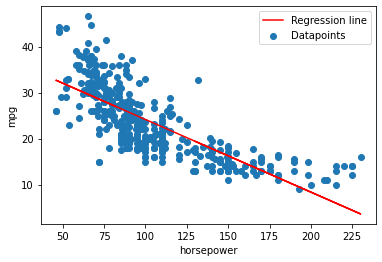

The regression line is: 
 y = -0.15784473335365365 x + 39.93586102117047


In [6]:
lm_sklearn = LinearRegression().fit(auto['horsepower'].values.reshape(-1, 1), auto['mpg'].values.reshape(-1, 1))
plt.scatter(auto['horsepower'].values, auto['mpg'].values)
# To plot the linear regression model:
x = auto['horsepower'].values
y_pred = lm_sklearn.predict(x.reshape(-1, 1))
plt.plot(x, y_pred, color='r')
plt.legend(['Regression line', 'Datapoints'])
plt.xlabel('horsepower')
plt.ylabel('mpg')
plt.show()
# Regression line coefficients:
print(f'The regression line is: \n y = {lm_sklearn.coef_[0][0]} x + {lm_sklearn.intercept_[0]}')

Using `scikit-learn` (below), we obtain the same results!

The relationship between the predictor and the response can be expressed by the $R^2$ measure: 

In [7]:
# R = (1 - RSS/TSS)
RSS = np.sum((y.reshape(-1, 1) - lm.predict(x))**2)
TSS = np.sum((y.reshape(-1, 1) - np.mean(y))**2)
r2 = 1 - RSS/TSS
print(f"R2 score: {r2}")

R2 score: 0.6059482578894348


There is a relationship between the predictor and the response, but this relationship does not seem to be linear. \
As done earlier, let's confirm that the value of $R^2$ I calculated is correct by checking the `sklearn.metrics` library:

In [8]:
# The R^2 score is computed as r2_score(y_true, y_pred)
r2 = r2_score(auto['mpg'], y_pred)
print(f'The R^2 score is: {r2}')

The R^2 score is: 0.6059482578894348


The predicted `mpg` for `horsepower` = 98 is:

In [9]:
result = lm.predict(np.array([98]))[0][0]
print(result)

24.467077152512424


The last question asks the associated *confidence intervals* and *prediction intervals*. 

#### Confidence interval <span style="background-color: #FFC300">[Theory]</span>
The confidence interval (CI) represents an interval that includes with X% probability **the mean** of the all the predicted values $\hat{y}$ for a given $x$. A 95% CI means that, if we calculate the linear regression model 100 times on random samples, the interval will contain the mean $\hat(y)$ for any value in the $x$ domain 95 times. 

The 95% confidence interval is calculated as follows: 

$$ \hat{y} \pm t_{\alpha \ / \ 2 } \ s_{\hat{y}}$$

where $t_{\alpha \ / \ 2 }$ is the t-statistics for $\text{dof} = N-2$, and $s_{\hat{y}}$ is the estimated standard deviation of $\hat{y}$. 
The value $s_{\hat{y}}$ is calculated as:

$$ s_{\hat{y}} = \sigma \sqrt{ \frac{1}{N} + \frac{(x^* - \overline{x})^2}{\sum{(x_i - \overline{x}})^2} }$$ 

where $x^*$ is represents every value on the $x$-axis and $\overline{x}$ is the mean of $x$.


#### Prediction interval <span style="background-color: #FFC300">[Theory]</span>
The prediction interval (CI) represents an interval that includes with X% probability **the actual prediction** for a given $x$. This is different than before, where we were focusing on the mean of the predictions. A 95% PI means that, if we calculate the linear regression model 100 times on random samples, the interval will contain the 95 predictions for that given $x$.

The 95% prediction interval is calculated as follows: 

$$ \hat{y}^* \pm t_{\alpha \ / \ 2 } \ s_{pred}$$

where $t_{\alpha \ / \ 2 }$ is the t-statistics for $\text{dof} = N-2$, and $s_{pred}$ is the estimated standard deviation of $\hat{y}^*$. 

$$ s_{pred}^2 = s_{\hat{y}}^2 + \sigma^2 $$

Then, $s_{pred}$ is calculated as:

$$ s_{pred} = \sigma \sqrt{1 + \frac{1}{N} + \frac{(x^* - \overline{x})^2}{\sum{(x_i - \overline{x}})^2} }$$ 

---


Using this formula, the 95% CI for `horsepower` = 98 is:

In [10]:
value_horsepower = 98
x = auto['horsepower'].values
y = auto['mpg'].values

# Method for CI 95%
def conf_int_95(x, y, value):
    N = x.shape[0]
    y_hat = np.ravel(lm.predict(x))
    std_dev = math.sqrt(np.sum((y - y_hat)**2) / (y.shape[0] - 1))
    # Compute using formula above
    s_yhat = std_dev * math.sqrt((1 / N) + ((value - np.mean(x))**2 / np.sum((x - np.mean(x))**2)))

    # Prediction
    predicted_value = lm.predict(np.array([value]))[0][0]    #[0][0] necessary because it returns [[value]]

    # Calculate lower and upper bounds for 95% CI
    CI_lower_bound = predicted_value - 2 * s_yhat     # t ~ 2 with so many dof (N - 2)
    CI_upper_bound = predicted_value + 2 * s_yhat    # t ~ 2 with so many dof (N - 2)
    return np.array([CI_lower_bound, CI_upper_bound])

# print result
print(f'The 95% confidence interval is: [{conf_int_95(x, y, value_horsepower)[0]}, {conf_int_95(x, y, value_horsepower)[1]}]')

The 95% confidence interval is: [23.96519548226853, 24.968958822756317]


In [11]:
# Method for PI 95%
def pred_int_95(x, y, value):
    N = x.shape[0]
    y_hat = np.ravel(lm.predict(x))
    std_dev = math.sqrt(np.sum((y - y_hat)**2) / (y.shape[0] - 1))
    # Compute using formula above
    s_yhat_pred = std_dev * math.sqrt(1 + ((1 / N) + (value - np.mean(x))**2 / np.sum((x - np.mean(x))**2)))
    predicted_value = lm.predict(np.array([value]))[0][0]    #[0][0] necessary because it returns [[value]]
    PI_lower_bound = predicted_value - 2 * s_yhat_pred     # t ~ 2 with so many dof (N - 2)
    PI_upper_bound = predicted_value + 2 * s_yhat_pred    # t ~ 2 with so many dof (N - 2)
    return np.array([PI_lower_bound, PI_upper_bound])

print(f'The 95% prediction interval is: [{pred_int_95(x, y, value_horsepower)[0]}, {pred_int_95(x, y, value_horsepower)[1]}]')

The 95% prediction interval is: [14.65527380532948, 34.27888049969537]


The plot of the confidence interval and prediction interval is:

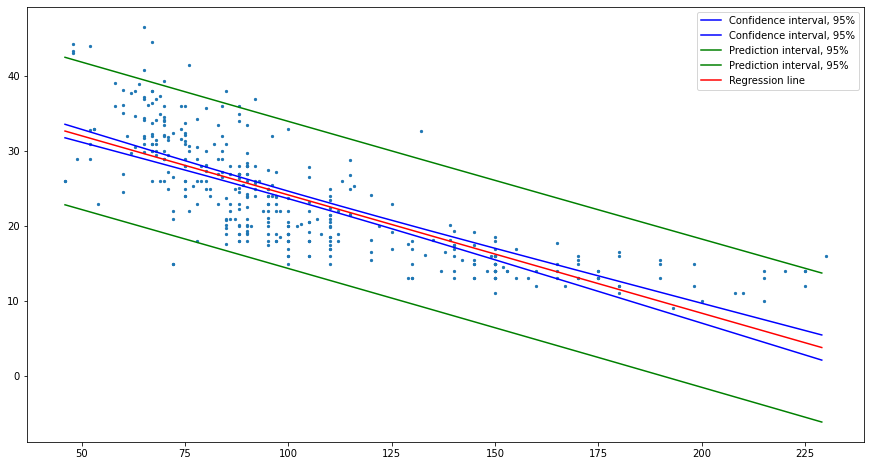

In [12]:
lm = Linear_Regression()
lm.fit(x, y, print_statistics = False)
predicted_values_line = lm.predict(np.arange(np.amin(auto['horsepower'].values), np.amax(auto['horsepower'].values), 1))
array_conf_intervals = []
array_pred_intervals = []
for i in range(np.amin(auto['horsepower'].values), np.amax(auto['horsepower'].values)):    # loop over x values  
    array_conf_intervals.append(conf_int_95(x, y, i))
    array_pred_intervals.append(pred_int_95(x, y, i))

plt.figure(figsize=(15, 8))
plt.plot(np.arange(np.amin(auto['horsepower'].values), np.amax(auto['horsepower'].values)), array_conf_intervals, c='b', label='Confidence interval, 95%')
plt.plot(np.arange(np.amin(auto['horsepower'].values), np.amax(auto['horsepower'].values)), array_pred_intervals, c='g', label='Prediction interval, 95%')
plt.plot(np.arange(np.amin(auto['horsepower'].values), np.amax(auto['horsepower'].values)), predicted_values_line, c='r', label='Regression line')
plt.scatter(auto['horsepower'].values, auto['mpg'].values, s=5)
plt.legend()
plt.show()

### 8.c

This question asks to analyze the result of the R function `lm().plot()`, that plots the Residual Analysis. \
Since I am not using R, I will develop a few methods to simulate the R `lm().plot()`: specifically, I will plot the *Residuals vs. Fitted*, *(Studentized) Residuals vs. Fitted* and the *Normal Q-Q*.

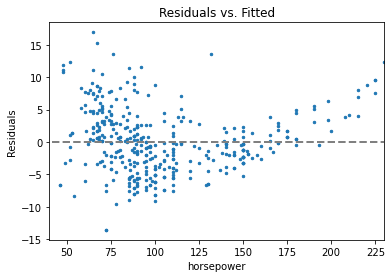

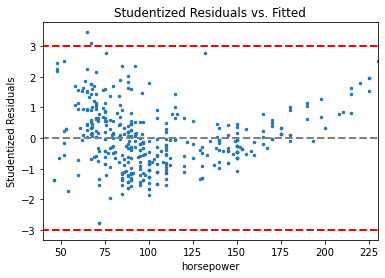

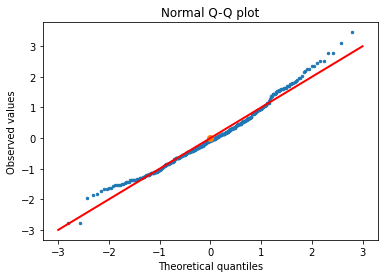

In [70]:
predictions = np.ravel(lm.predict(x))
residuals = y - np.ravel(predictions)

# Residuals vs. Fitted
plt.plot([0, 260], [0, 0], '--', c='0.5', lw=2)
plt.xlim([40, 230])
plt.scatter(x, residuals, s=6)
plt.xlabel('horsepower')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

# Studentized Residuals vs. Fitted
plt.plot([0, 260], [0, 0], '--', c='0.5', lw=2)
plt.scatter(x, residuals / np.std(residuals), s=6)
plt.xlabel('horsepower')
plt.ylabel('Studentized Residuals')
plt.title('Studentized Residuals vs. Fitted')
plt.plot([0, 260], [3, 3] ,'r--', lw=2)
plt.plot([0, 260], [-3, -3] ,'r--', lw=2)
plt.xlim([40, 230])
plt.show()

# Q-Q plot
residuals_sorted = np.sort(residuals)
studentized_residuals_sorted = np.sort(residuals/np.std(residuals))
list_percentiles = [i / (len(residuals_sorted) + 1) for i in range(1, len(residuals_sorted) + 1)] 
list_percentiles_expected_normal = scipy.stats.norm.ppf(list_percentiles)    # norm.ppf(X) is the gaussian value for the X-th percentile
plt.scatter(list_percentiles_expected_normal, studentized_residuals_sorted, s=6)
plt.plot([-3, 3], [-3, 3], 'r-', lw=2)
plt.scatter([0], [0])
plt.xlabel('Theoretical quantiles')
plt.ylabel('Observed values')
plt.title('Normal Q-Q plot')
plt.show()

As one can see:
- Residuals do not lie on the Q-Q line, thus they are not normally distributed.
- Heteroscedasticity: the variance is not constant. The linear model is not the best model that we could develop.
- Possible outliers: a few studentized residuals are higher than 3.

<a id='exercise-9'></a>
## Exercise 9

This exercise involves the use of multiple linear regression on the `Auto` dataset.

In [14]:
auto = pd.read_csv('data/Auto.csv')
auto.drop(auto[auto.values == '?'].index, inplace = True)
auto['horsepower'] = pd.to_numeric(auto['horsepower'])